# SDG&E Test System Data

This notebook is used to preprocess the data needed to create the San Diego test system model. Data manipulations performed in python to leverage `geopandas` library. 

In [30]:
# Libraries
import pylab as plt
import importlib
import os
from os.path import join
import networkx as nx
import numpy as np

# Modules
import utils
import graphtools
importlib.reload(utils)
importlib.reload(graphtools)
from utils import *
from graphtools import subset_system

# Path the data directory
DATA_DIR = join(os.getcwd(), '..', 'data')

In [16]:
# Read all CATS datasets (standardizing column names where needed)
buses = (read_geocsv('buses.csv')
         .rename(columns={'bus_i':'bus'})
        )

lines = (gpd
         .read_file(join(DATA_DIR, 'cats', 'lines.json'))
         .pipe(standardize)
         .rename(columns={'cats_id':'id', 'br_r':'r', 'br_x':'x', 'br_b':'b'})
        )

loads = read_loads('loads.csv')

gens = (read_mat('gencost.mat')
        .join(read_csv('generators.csv'))
        .pipe(add_id)
        )

# Read IOU shapefile and select SDG&E shape
ious = gpd.read_file(join(PATH, 'iou.geojson'))
sdge = ious[ious['Acronym'] == 'SDG&E'][['geometry']]

In [32]:
# Create a sub-system of lines, buses, and gens 
# Save all outputs to CSVs in the test-system folder
sub_lines, sub_buses, sub_gens = subset_system(sdge, lines, buses, gens, loads)

Created a system with 489 buses. Removed 2 isolated buses.


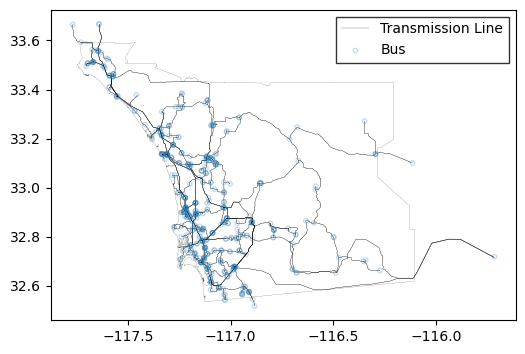

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
sub_lines.plot(ax=ax, color='k', lw=0.15, label="Transmission Line")
sub_buses.plot(ax=ax, zorder=2, alpha=0.25, facecolor='none', edgecolor='C0',  markersize=10, label="Bus")
sdge.plot(ax=ax, facecolor='none', edgecolor='k', lw = 0.1)
plt.legend(fancybox=False, edgecolor='k')
#plt.savefig("test_system.svg")

In [39]:
# Check that the subsystem is fully connected
graph = nx.from_pandas_edgelist(sub_lines, source='f_bus', target='t_bus')
print("System Connected:", 1==len(list(nx.connected_components(graph))))

System Connected: True
